Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

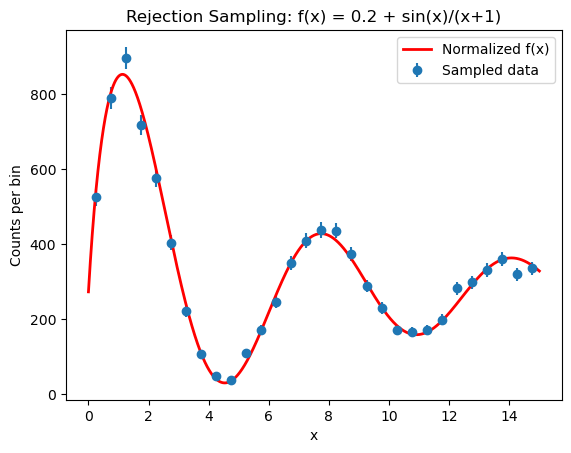

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- function definition ---
def f(x):
    return 0.2 + np.sin(x)/(x+1)

# range and settings
xmin, xmax = 0, 15
N = 10000  # number of accepted points
nbins = 30

# find max of f(x) for rejection
x_grid = np.linspace(xmin, xmax, 10000)
fmax = f(x_grid).max()

# --- rejection sampling ---
accepted = []
while len(accepted) < N:
    x_try = np.random.uniform(xmin, xmax, N)
    y_try = np.random.uniform(0, fmax, N)
    mask = y_try < f(x_try)
    accepted.extend(x_try[mask])
accepted = np.array(accepted[:N])

# --- histogram ---
counts, bins = np.histogram(accepted, bins=nbins, range=(xmin, xmax))
bin_centers = 0.5*(bins[1:]+bins[:-1])
errors = np.sqrt(counts)

# --- normalize function for comparison ---
# Normalize f(x) to area = 1
pdf_norm = f(x_grid) / np.trapezoid(f(x_grid), x_grid)
# Scale it to histogram counts (area = total counts)
pdf_scaled = pdf_norm * N * (xmax - xmin)/nbins

# --- plot ---
plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Sampled data')
plt.plot(x_grid, pdf_scaled, 'r-', lw=2, label='Normalized f(x)')
plt.xlabel('x')
plt.ylabel('Counts per bin')
plt.legend()
plt.title('Rejection Sampling: f(x) = 0.2 + sin(x)/(x+1)')
plt.show()


2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

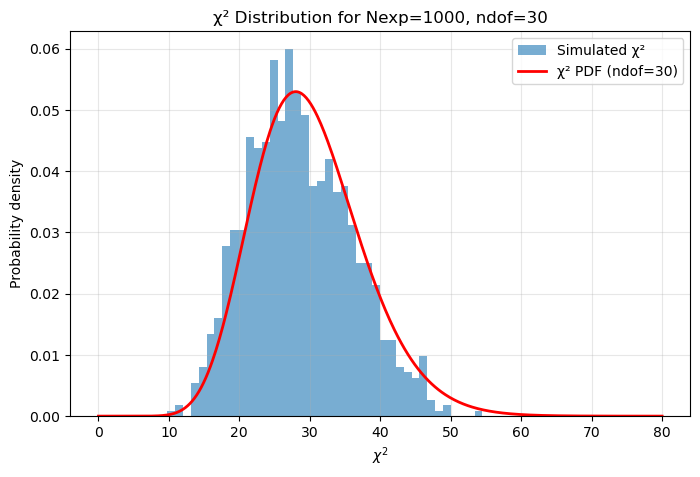

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# --- model function ---
def f(x):
    return 0.2 + np.sin(x)/(x+1)

# --- parameters ---
xmin, xmax = 0, 15
nbins = 30
Npoints = 10000
Nexp = 1000

# grid and normalization
x_grid = np.linspace(xmin, xmax, 10000)
f_vals = f(x_grid)
pdf_norm = f_vals / np.trapezoid(f_vals, x_grid)  # normalized to 1

# expected probability per bin
bins = np.linspace(xmin, xmax, nbins+1)
bin_width = bins[1]-bins[0]
# integrate pdf in each bin to get expected probabilities
f_expected = np.array([
    np.trapezoid(f(x_grid[(x_grid>=bins[i]) & (x_grid<bins[i+1])]), 
                 x_grid[(x_grid>=bins[i]) & (x_grid<bins[i+1])])
    for i in range(nbins)
])
f_expected /= np.sum(f_expected)  # total = 1

# find fmax for rejection sampling
fmax = f_vals.max()

def rejection_sample(N):
    accepted = []
    while len(accepted) < N:
        x_try = np.random.uniform(xmin, xmax, N)
        y_try = np.random.uniform(0, fmax, N)
        mask = y_try < f(x_try)
        accepted.extend(x_try[mask])
    return np.array(accepted[:N])

# --- repeat experiment ---
chi2_values = []
for _ in range(Nexp):
    data = rejection_sample(Npoints)
    counts, _ = np.histogram(data, bins=bins)
    expected_counts = f_expected * Npoints
    # avoid divide-by-zero
    mask = expected_counts > 0
    chi2_val = np.sum(((counts[mask]-expected_counts[mask])**2) / expected_counts[mask])
    chi2_values.append(chi2_val)

chi2_values = np.array(chi2_values)

# --- plot χ² distribution ---
plt.figure(figsize=(8,5))
plt.hist(chi2_values, bins=40, density=True, alpha=0.6, label="Simulated χ²")
x = np.linspace(0, 80, 500)
plt.plot(x, chi2.pdf(x, df=nbins), 'r-', lw=2, label=r'χ² PDF (ndof=30)')
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability density')
plt.title(r'χ² Distribution for Nexp=1000, ndof=30')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

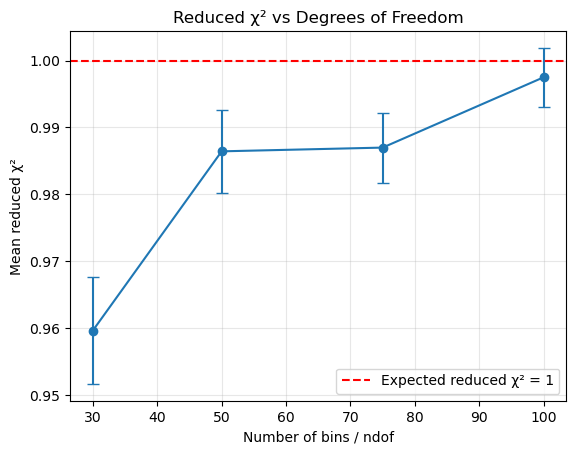

    ndof    Mean Reduced χ²       StdErr     Expected
      30              0.960        0.008        1.000
      50              0.986        0.006        1.000
      75              0.987        0.005        1.000
     100              0.998        0.004        1.000


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# --- model function ---
def f(x):
    return 0.2 + np.sin(x)/(x+1)

# --- constants ---
xmin, xmax = 0, 15
Npoints = 10000
Nexp = 1000
ndof_list = [30, 50, 75, 100]

# grid for normalization
x_grid = np.linspace(xmin, xmax, 20000)
f_vals = f(x_grid)
pdf_norm = f_vals / np.trapezoid(f_vals, x_grid)
fmax = f_vals.max()

# rejection sampler
def rejection_sample(N):
    accepted = []
    while len(accepted) < N:
        x_try = np.random.uniform(xmin, xmax, N)
        y_try = np.random.uniform(0, fmax, N)
        mask = y_try < f(x_try)
        accepted.extend(x_try[mask])
    return np.array(accepted[:N])

# storage for results
mean_reduced = []
std_reduced  = []

# loop over ndof values
for nbins in ndof_list:
    bins = np.linspace(xmin, xmax, nbins + 1)
    # expected probability in each bin
    f_expected = np.array([
        np.trapezoid(f(x_grid[(x_grid>=bins[i]) & (x_grid<bins[i+1])]),
                     x_grid[(x_grid>=bins[i]) & (x_grid<bins[i+1])])
        for i in range(nbins)
    ])
    f_expected /= np.sum(f_expected)

    chi2_vals = []
    for _ in range(Nexp):
        data = rejection_sample(Npoints)
        counts, _ = np.histogram(data, bins=bins)
        expected_counts = f_expected * Npoints
        mask = expected_counts > 0
        chi2_val = np.sum(((counts[mask]-expected_counts[mask])**2)/expected_counts[mask])
        chi2_vals.append(chi2_val / nbins)   # reduced χ²

    chi2_vals = np.array(chi2_vals)
    mean_reduced.append(np.mean(chi2_vals))
    std_reduced.append(np.std(chi2_vals)/np.sqrt(Nexp))  # error on mean

# --- plot ---
plt.errorbar(ndof_list, mean_reduced, yerr=std_reduced, fmt='o-', capsize=4)
plt.axhline(1, color='r', ls='--', label='Expected reduced χ² = 1')
plt.xlabel('Number of bins / ndof')
plt.ylabel('Mean reduced χ²')
plt.title('Reduced χ² vs Degrees of Freedom')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- table ---
print(f"{'ndof':>8} {'Mean Reduced χ²':>18} {'StdErr':>12} {'Expected':>12}")
for nd, m, s in zip(ndof_list, mean_reduced, std_reduced):
    print(f"{nd:8d} {m:18.3f} {s:12.3f} {1.000:12.3f}")
